In [19]:
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools

In [13]:
# Cargar el modelo
model_resize = load_model('Saved_Models/model_resize_15-15.h5')

# Cargar la lista de historias
with open('Saved_Models/histories_resize_15-15.pkl', 'rb') as file:
    history_list_resize = pickle.load(file)
    
# Cargar el modelo
model_crop = load_model('Saved_Models/model_crop_20-30.h5')

# Cargar la lista de historias
with open('Saved_Models/histories_crop_20-30.pkl', 'rb') as file:
    history_list_crop = pickle.load(file)

In [33]:
def show_acc_loss(history_list, title):
    # Crear una figura y ejes para el gráfico
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    history_acc = []
    history_val_acc = []
    history_loss = []
    history_val_loss = []

    # Recopilar las precisiones (accuracy) de todas las historias en history_list
    for history in history_list:
        history_acc.extend(history['acc'])
        history_val_acc.extend(history['val_acc'])
        history_loss.extend(history['loss'])
        history_val_loss.extend(history['val_loss'])

    # Graficar la precisión (accuracy) en función de las épocas
    axes[0].plot(history_acc, label='Train Accuracy')
    axes[0].plot(history_val_acc, label='Validation Accuracy')
    axes[0].set_title('Accuracy ' + title)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history_loss, label='Train Loss')
    axes[1].plot(history_val_loss, label='Validation Loss')
    axes[1].set_title('Loss ' + title)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

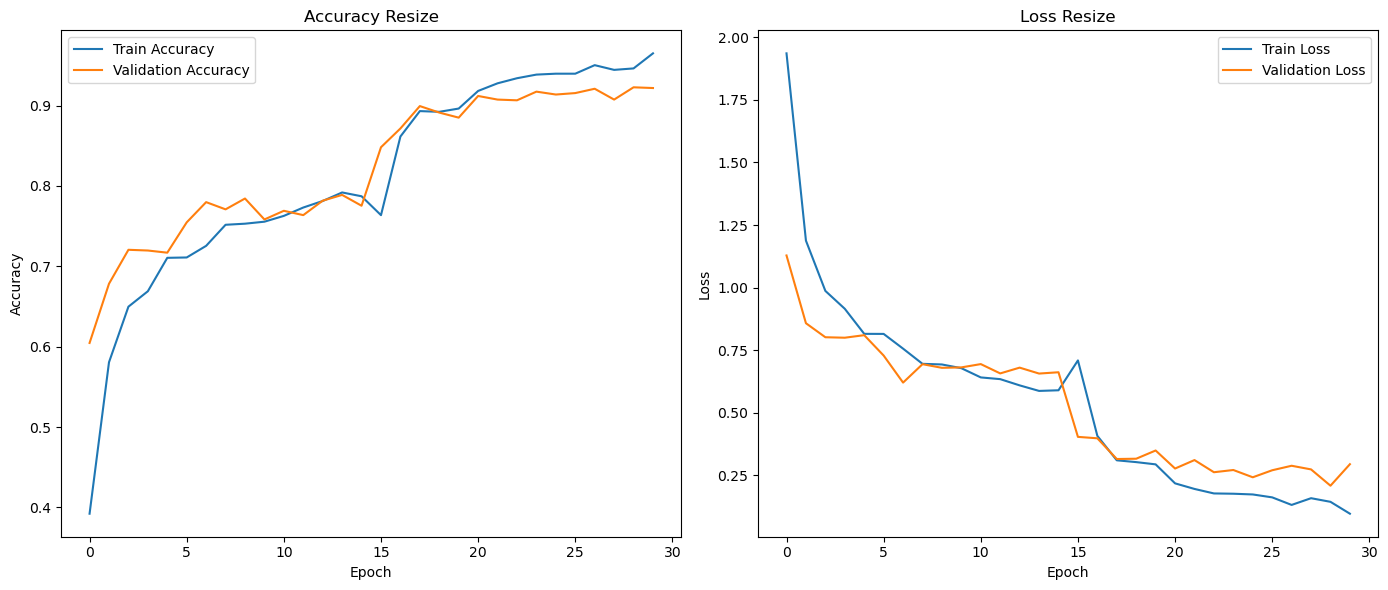

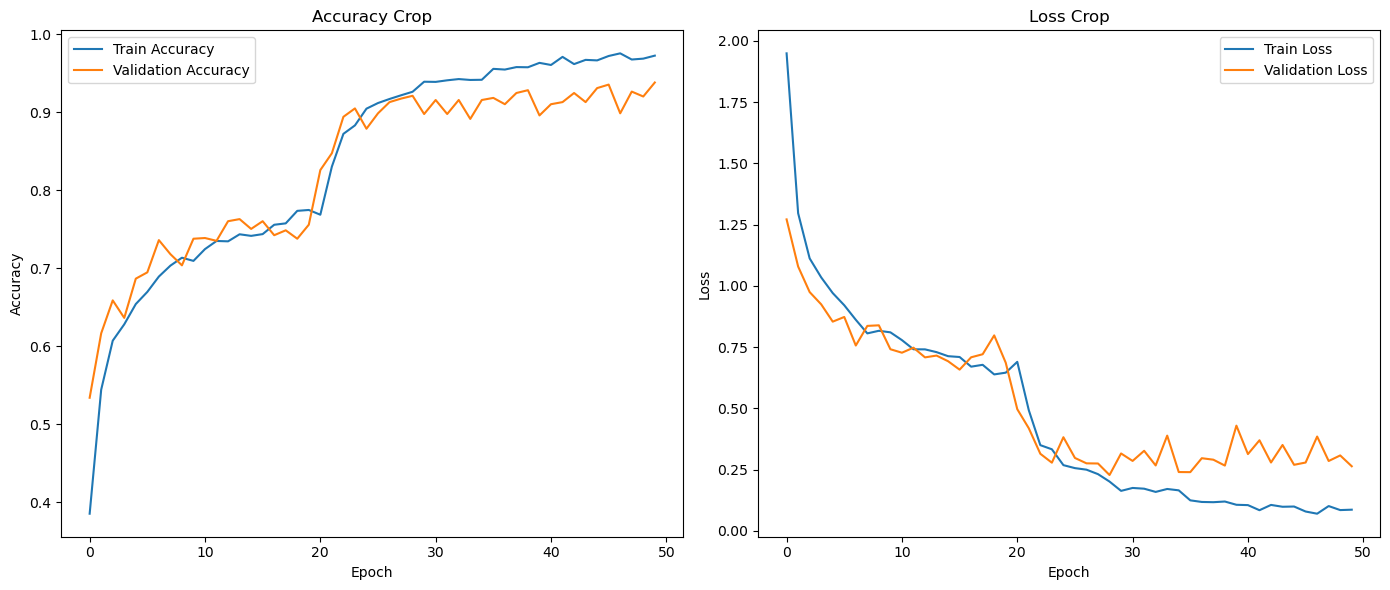

In [34]:
show_acc_loss(history_list_resize, "Resize")
show_acc_loss(history_list_crop, "Crop")

In [24]:
def make_predictions(test_images_route, model):
    # Volvemos a definir el test_generator con shuffle=False.
    # Esto desactiva la mezcla aleatoria de los datos en cada época durante el proceso de evaluación lo cual es útil para asegurarte
    # de que las predicciones coincidan con las etiquetas en el orden correcto.

    batch_size = 64

    test_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input)

    test_generator = test_data_generator.flow_from_directory(directory=test_images_route,
                                                             class_mode ="sparse",
                                                            target_size = (224 , 224),
                                                            batch_size = batch_size,
                                                            shuffle=False)

    # Obtener el número total de muestras en el conjunto de prueba
    num_samples_test = test_generator.samples
    print("num_samples_test", num_samples_test)

    # Obtener las etiquetas reales del conjunto de prueba
    y_true = test_generator.classes

    # Realizar predicciones en el conjunto de prueba
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

    # Convertir las predicciones continuas en clases
    predicted_classes = np.argmax(predictions, axis=1)

    print("length y_true", len(y_true))
    print("length predicted_classes", len(predicted_classes))

    # Mostrar el classification report
    print(classification_report(y_true, predicted_classes))
    
    return y_true, predicted_classes

In [26]:
y_true_resize, predicted_classes_resize = make_predictions("../Test_original", model_resize) # Test_original is resized

Found 1113 images belonging to 12 classes.
num_samples_test 1113
18/18 [==============================] - 102s 6s/step
length y_true 1113
length predicted_classes 1113
              precision    recall  f1-score   support

           0       0.89      0.39      0.54        62
           1       0.99      0.99      0.99        91
           2       0.99      1.00      0.99        67
           3       0.91      0.97      0.94       143
           4       0.91      0.94      0.92        51
           5       0.91      0.92      0.91       108
           6       0.81      0.96      0.88       153
           7       1.00      0.92      0.96        52
           8       0.89      0.97      0.93       122
           9       1.00      0.78      0.88        55
          10       1.00      0.99      1.00       116
          11       0.95      0.95      0.95        93

    accuracy                           0.92      1113
   macro avg       0.94      0.90      0.91      1113
weighted avg       0

In [25]:
y_true_crop, predicted_classes_crop = make_predictions("../Test", model_crop) # Test is crop

Found 1113 images belonging to 12 classes.
num_samples_test 1113
18/18 [==============================] - 95s 5s/step
length y_true 1113
length predicted_classes 1113
              precision    recall  f1-score   support

           0       0.89      0.50      0.64        62
           1       1.00      0.98      0.99        91
           2       1.00      1.00      1.00        67
           3       0.96      0.97      0.96       143
           4       0.83      0.98      0.90        51
           5       0.97      0.95      0.96       108
           6       0.85      0.95      0.90       153
           7       0.94      0.98      0.96        52
           8       0.93      0.96      0.94       122
           9       0.93      0.91      0.92        55
          10       1.00      1.00      1.00       116
          11       0.96      0.92      0.94        93

    accuracy                           0.94      1113
   macro avg       0.94      0.93      0.93      1113
weighted avg       0.

In [49]:
def show_confusion_matrix(y_true, predicted_classes, title):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, predicted_classes)

    # Normalize the confusion matrix to show percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Get class names from test_generator class indices
    class_names = list(test_generator.class_indices.keys())

    #plt.figure()
    plt.figure(figsize=(10, 8))

    plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix (%) " + title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm_percent[i, j]:.1f}",  # Display percentage value
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > (cm_percent.max() / 2) else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted Labels')

    plt.show()

    accuracy = 100 * (np.trace(cm) / np.sum(cm))
    print("Accuracy =", f"{accuracy:.0f}", "%")

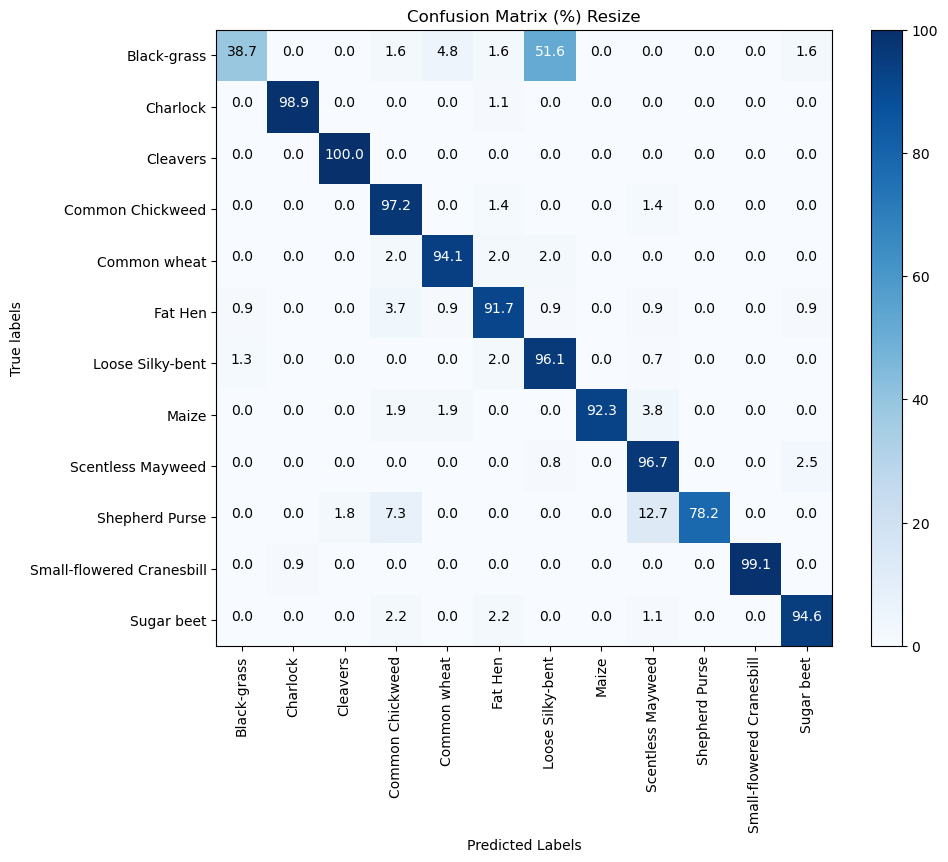

Accuracy = 92 %


In [50]:
show_confusion_matrix(y_true_resize, predicted_classes_resize, "Resize")

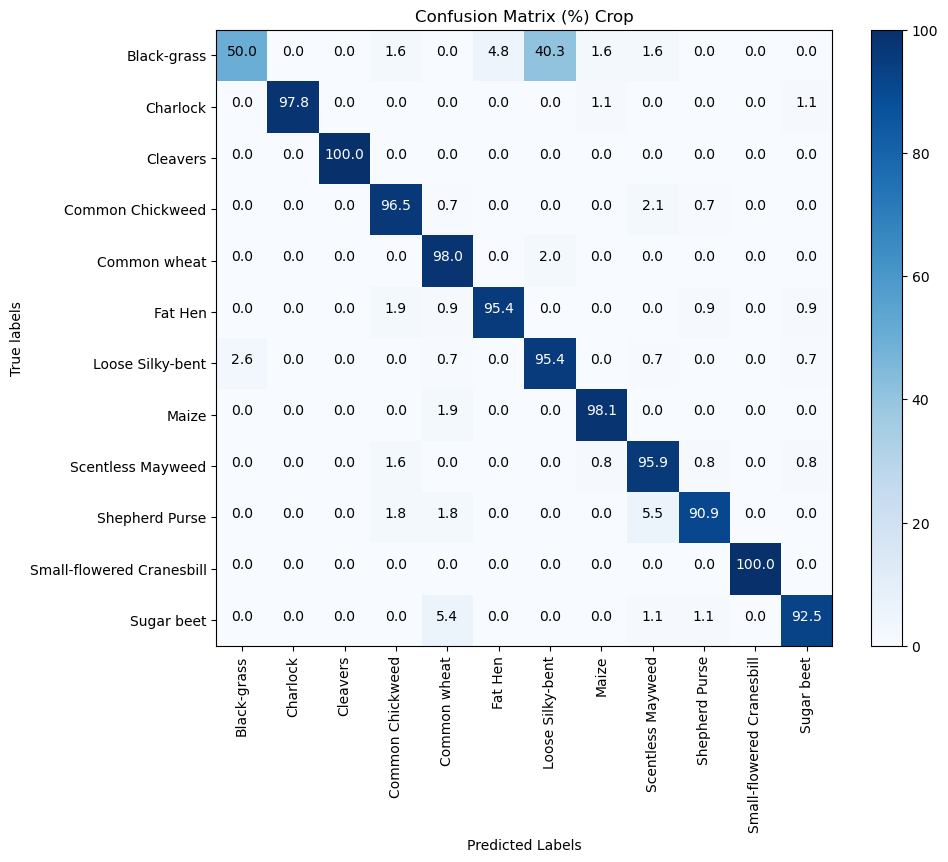

Accuracy = 94 %


In [51]:
show_confusion_matrix(y_true_crop, predicted_classes_crop, "Crop")